# Log Analytics - USX Manager (REST Calls Log)

This notebook provides a quick summary analytics on the REST api calls made to an USX Management Server. 

The input to this notebook could be either usx-manager-requests.log / usxm-agent-requests.log 

In [2]:
%matplotlib inline

from IPython.core.display import HTML
from IPython.display import Image

# Libraries
import apachelog, sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as npb
import pandas as pd
import datetime as dt
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter
from seasonal import fit_seasons, adjust_seasons, fit_trend

import seaborn as sns

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

### USXM REST Calls Log

Below is the format of the log and a short description of every element:
    
    format = r'%h  %l %u %t \"%r\" %>s %b \"%i\" \"%{User-Agent}i\" %T'
    
    %V          - the server name according to the UseCanonicalName setting
    %h          - remote host (ie the client IP)
    %l          - identity of the user determined by identd (not usually used since not reliable)
    %u          - user name determined by HTTP authentication
    %t          - time the server finished processing the request.
    %r          - request line from the client. ("GET / HTTP/1.0")
    %>s         - status code sent from the server to the client (200, 404 etc.)
    %b          - size of the response to the client (in bytes)
    \"%i\"      - Referer is the page that linked to this URL.
    User-agent  - the browser identification string
    %T          - Apache request time  

#### Sample Log Statement

10.19.14.134 - - [26/Aug/2016:06:32:21 +0000] "GET /usxmanager/metrics?target=alias(summarize(*.%7BUSX_8b8419cf-9193-330e-a7f6-f8a9bbcfdc3b%7D.VolumeCapOffloadCollector.%7BCapacity_Offload_Percent%7D,%225min%22,%22avg%22),%22Deduplication%20Ratio%20(%25)%22)&from=-1hours&until=now&format=json&lineMode=connected&noCache=true&width=500&height=250&jsonp=jQuery1110014890684454986425_1472191760944&_=1472191761024 HTTP/1.1" 200 - "https://10.19.12.100:8443/index.html" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36" 24


In [4]:
# Functions
def dash2nan(x):
    if x == '-':
        x = np.nan
    else:
        x = int(x)/1024
    return x

def gmet(x):
    x = x.split()
    return x[0]

def read_web_log(filename):
    # Create format
    logformat =  r"%h %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-agent}i\" %T"

    # Create parser
    logparser = apachelog.parser(logformat)
    
    log = open(filename).readlines()
    log_list = []
    for line in log:
       try:
          data = logparser.parse(line)
       except:
          sys.stderr.write("Unable to parse %s" % line)
       data['%t'] = data['%t'][1:12]+' '+data['%t'][13:21]+' '+data['%t'][22:27]
       log_list.append(data)
        
    # Convert to dataframe
    df = pd.DataFrame(log_list)
    
    # Rename columns
    df = df.rename(columns={'%>s': 'Status', '%b':'Size','%h':'USX_IP', '%r':'Request', '%t': 'Time'})
    
    # Convert Time column to datetime format and make an index out of it (pop will drop original Time column):
    df.index = pd.to_datetime(df.pop('Time'))
    
    # Convert Status variable to int:
    df['Status'] = df['Status'].astype('int')

    # Convert '-' to NA for b column
    df['Size'] = df['Size'].apply(dash2nan)
    
    # Populate method columns
    df['Method'] = df.Request.apply(gmet)
    
    return df[['Status', 'USX_IP', 'Method', 'Request','Size']]

def get_method_ip_stats(df):
    method_ip = df.groupby(['Method', 'USX_IP']).size()
    return method_ip

def get_ip_status_stats(df):
    ips_status = df.groupby(['USX_IP', 'Status']).size()
    ips_status.sort_values(inplace=True, ascending=False)
    return ips_status

def get_status_details(df, t_span='H'):
    df_200 = df['Status'][df['Status'] == 200].resample(t_span, how='count')
    df_204 = df['Status'][df['Status'] == 204].resample(t_span, how='count')
    df_302 = df['Status'][df['Status'] == 302].resample(t_span, how='count')
    df_304 = df['Status'][df['Status'] == 304].resample(t_span, how='count')
    df_400 = df['Status'][df['Status'] == 400].resample(t_span, how='count')
    df_401 = df['Status'][df['Status'] == 401].resample(t_span, how='count')
    df_403 = df['Status'][df['Status'] == 403].resample(t_span, how='count')
    df_404 = df['Status'][df['Status'] == 404].resample(t_span, how='count')
    df_499 = df['Status'][df['Status'] == 499].resample(t_span, how='count')
    df_500 = df['Status'][df['Status'] == 500].resample(t_span, how='count')
    df_502 = df['Status'][df['Status'] == 502].resample(t_span, how='count')
    df_504 = df['Status'][df['Status'] == 504].resample(t_span, how='count')
    
    status_df = pd.DataFrame({'OK':df_200, 'No Content':df_204, 'Not Modified':df_304, 
                              'Bad Request':df_400, 'Not Found':df_404, 'UnAuthorized':df_401,
                              'Forbidden':df_403, 'Server Error':df_500, 'Bad Gateway':df_502, 'Gateway Timeout':df_504,})
    status_df.fillna(0, inplace=True)
    return status_df

def create_line_plot(metric_name, series):
    '''
        Create line plot using seaborn
    '''
    # Create line chart
    fig = plt.figure(figsize=(15, 6))
    fig.suptitle(metric_name + ' Chart', fontsize=12, fontweight='bold')
    ax = plt.gca()
    ax.xaxis.set_major_locator(HourLocator(interval=12))
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d %I:%M %p')) # TimeFormat : http://strftime.org/
    plt.plot(series, color='steelblue')
    plt.xlabel("timestamp", fontweight='bold')
    plt.ylabel(metric_name)
    plt.gcf().autofmt_xdate()
    return

In [5]:
print("Reading the log file...Printing last 10 log statements in table form...")
df = read_web_log('data/usxm-server-request.log')
df.tail(10)

Reading the log file...Printing last 10 log statements in table form...


,Status,USX_IP,Method,Request,Size
Time,,,,,
2016-09-08 22:31:59,200,10.1.0.70,GET,GET /console/img/favicon.ico HTTP/1.1,NaN
2016-09-08 22:31:59,200,10.1.0.70,GET,GET /console/js/flat-ui.min.js HTTP/1.1,NaN
2016-09-08 22:31:59,200,10.1.0.70,GET,GET /console/img/banner_usx-logo.png HTTP/1.1,NaN
2016-09-08 22:31:59,401,10.1.0.70,GET,GET /usxmanager/usxmanager HTTP/1.1,0
2016-09-08 22:31:59,200,10.1.0.70,GET,GET /console/login.html HTTP/1.1,NaN
2016-09-08 22:31:59,200,10.1.0.70,GET,GET /console/css/login.css HTTP/1.1,NaN
2016-09-08 22:31:59,200,10.1.0.70,GET,GET /console/js/login.js HTTP/1.1,NaN
2016-09-08 22:31:59,200,10.1.0.70,GET,GET /console/img/login_background.jpg HTTP/1.1,NaN
2016-09-08 22:32:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0


### REST API Calls stats....

**Note on API Method Types:** -

1. **GET** = Get Data
2. **POST** = Create Config Data
3. **PUT** = Update Config Data
4. **DELETE** = Delete Config


Top 10: 


,"(Method, USX_IP)",Count
0,"(PUT, 127.0.0.1)",17536
1,"(GET, 127.0.0.1)",11314
2,"(GET, 10.19.12.100)",10440
3,"(PUT, 10.19.12.101)",10289
4,"(GET, 10.19.12.101)",9218
5,"(GET, 10.19.12.102)",9206
6,"(PUT, 10.19.12.102)",7898
7,"(POST, 10.19.12.101)",6163
8,"(POST, 10.19.12.102)",6146
9,"(GET, 10.19.15.236)",2396


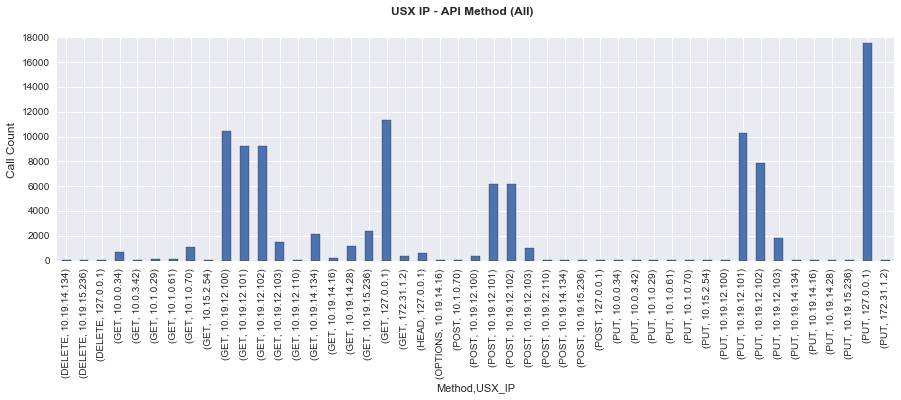

In [6]:
method_ip = get_method_ip_stats(df)
fig = plt.figure(figsize=(15, 4))
fig.suptitle('USX IP - API Method (All)', fontsize=12, fontweight='bold', verticalalignment='baseline')
g= method_ip.plot(kind='bar')
g.set_ylabel("Call Count", fontsize=12)

method_ip.sort_values(ascending=False, inplace=True)
df1 = pd.DataFrame({'(Method, USX_IP)':method_ip.index, 'Count':method_ip.values})
print("Top 10: ")
df1.head(10)

**API Calls Status Codes:**    
* 101  -      Success   - Switching Protocols
* 200  -      Success   - OK 
* 204  -      Success   - No Content 
* 302  -      Success   - Found
* 304  -      Success   - Not modified
* 400  -      Success   - Bad request
* 404  -      Success   - Not Found
* 401  -      Success   - Unauthorized
* 403  -      Success   - Forbidden
* 499  -      Failure   - Client closed request
* 500  -      Failure   - Internal server error
* 502  -      Failure   - Bad Gateway
* 504  -      Failure   - Gateway timeout


Top 10: 


,"(USX_IP, API Response)",Count
0,"(127.0.0.1, 200)",29502
1,"(10.19.12.101, 200)",25670
2,"(10.19.12.102, 200)",23249
3,"(10.19.12.100, 200)",10779
4,"(10.19.12.103, 200)",4312
5,"(10.19.15.236, 200)",2247
6,"(10.19.14.134, 200)",1764
7,"(10.1.0.70, 200)",1059
8,"(10.19.14.28, 200)",1053
9,"(10.0.0.34, 200)",485


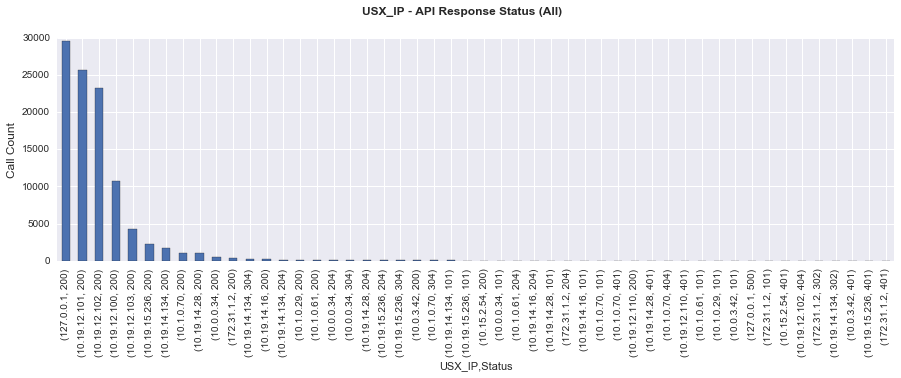

In [7]:
ips_status = get_ip_status_stats(df)
fig = plt.figure(figsize=(15, 4))
fig.suptitle('USX_IP - API Response Status (All)', fontsize=12, fontweight='bold', verticalalignment='baseline')
g = ips_status.plot(kind='bar')
g.set_ylabel("Call Count", fontsize=12)

ips_status.sort_values(ascending=False, inplace=True)
df1 = pd.DataFrame({'(USX_IP, API Response)':ips_status.index, 'Count':ips_status.values})
print("Top 10: ")
df1.head(10)

#### Aggregated on hourly scale....

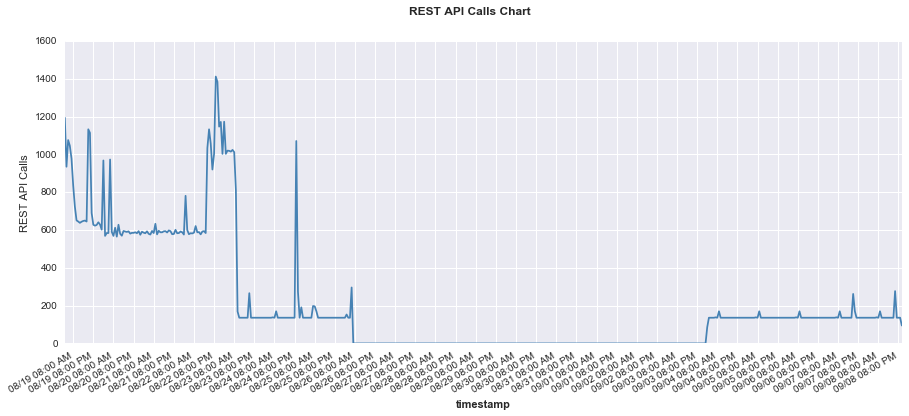

In [8]:
df_s = df['Request'].resample('1H', how='count')
create_line_plot("REST API Calls", df_s)

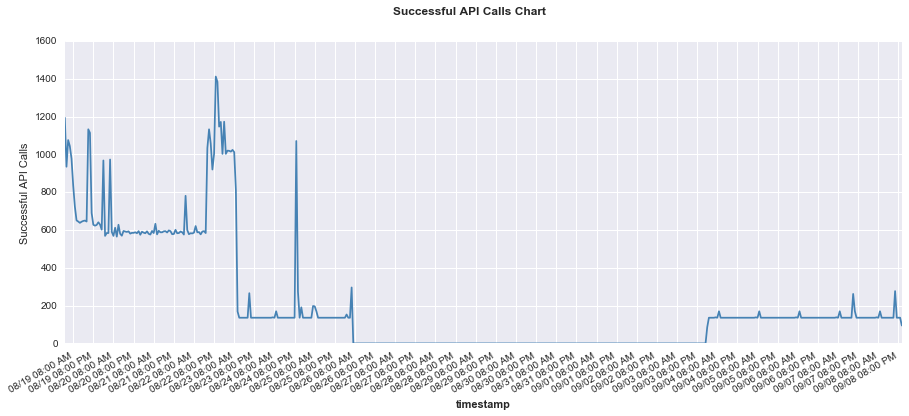

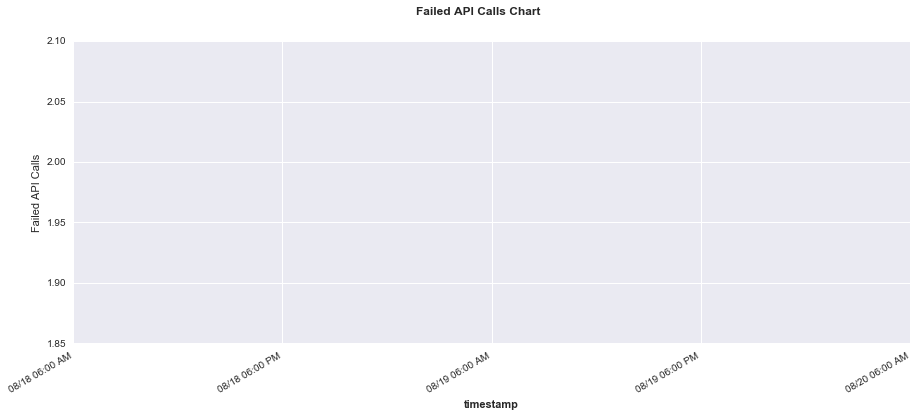

In [9]:
success_df = df[df['Status'].isin([101, 200, 204, 302, 304, 400, 401, 403, 404])].resample("1H", how='count')
fail_df = df[df['Status'].isin([499, 500, 502, 504])].resample("1H", how='count')

create_line_plot("Successful API Calls", success_df['Status'])
create_line_plot("Failed API Calls", fail_df['Status'])


### Top REST API Calls...

Top 10 REST API Calls...

In [10]:
g = df['Request'].value_counts().head(10) 
df1 = pd.DataFrame({'REST API Call':g.index, 'Count':g.values})
df1

,Count,REST API Call
0,17230,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...
1,7220,PUT /usxmanager/usx/inventory/volume/resources...
2,6971,GET /usxmanager/usxmanager HTTP/1.1
3,6899,GET /usxmanager/usx/inventory/volume/container...
4,6898,GET /usxmanager/usx/inventory/servicevm/contai...
5,6107,POST /usxmanager/usx/status/update?api_key=USX...
6,6104,GET /usxmanager/usx/inventory/volume/resources...
7,6094,GET /usxmanager/usx/inventory/volume/resources...
8,6090,POST /usxmanager/usx/status/update?api_key=USX...
9,4835,PUT /usxmanager/usx/inventory/volume/resources...


Top REST API calls response status & count **aggregated at hourly** scale....

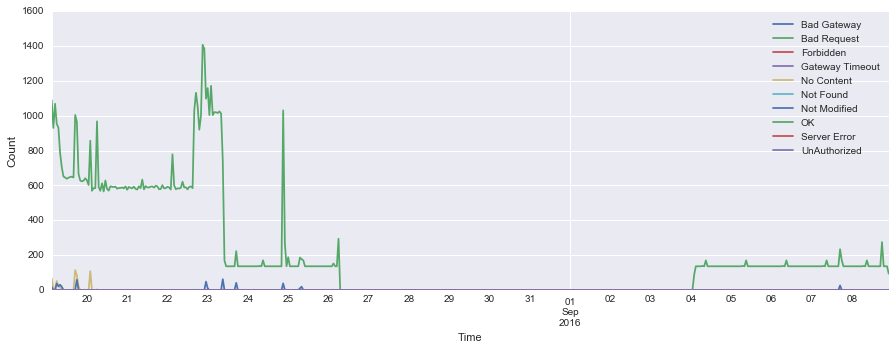

In [11]:
status_df = get_status_details(df)
g = status_df.plot(kind='line', figsize=(15, 5))
g.set_ylabel("Count", fontsize=12)

Last 10 hours in tabular form...

In [12]:
status_df.tail(10)

,Bad Gateway,Bad Request,Forbidden,Gateway Timeout,No Content,Not Found,Not Modified,OK,Server Error,UnAuthorized
Time,,,,,,,,,,
2016-09-08 13:00:00,0,0,0,0,0,0,0,136,0,0
2016-09-08 14:00:00,0,0,0,0,0,0,0,136,0,0
2016-09-08 15:00:00,0,0,0,0,0,0,0,136,0,0
2016-09-08 16:00:00,0,0,0,0,0,0,0,136,0,0
2016-09-08 17:00:00,0,0,0,0,0,0,0,136,0,0
2016-09-08 18:00:00,0,0,0,0,0,0,0,275,0,0
2016-09-08 19:00:00,0,0,0,0,0,0,0,136,0,0
2016-09-08 20:00:00,0,0,0,0,0,0,0,136,0,0
2016-09-08 21:00:00,0,0,0,0,0,0,0,136,0,0


### Stats on REST API whose response size is greater than 2 KB

How many REST API calls whose response size is > 2 KB?

,Call Count,Response Size (KB)
0,1980,6
1,293,4
2,79,5
3,36,3
4,8,7


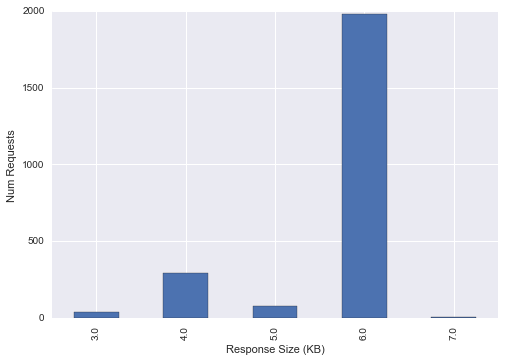

In [13]:
# Choose all requests with the size of the response larger than 2 Kb (remember we convert bytes to KB):
df_2kb = df[df['Size']> 2]
grouped_status = df_2kb.groupby('Size')
g=grouped_status.size().plot(kind='bar')
g.set_xlabel("Response Size (KB)")
g.set_ylabel("Num Requests")

temp = df_2kb['Size'].value_counts()
temp.sort_values(ascending=False, inplace=True)
df1 = pd.DataFrame({'Response Size (KB)':temp.index, 'Call Count':temp.values})
df1

Which nodes are invoking these rest api calls and how many calls?

,Call Count,USX_IP
0,1362,127.0.0.1
1,1032,10.19.12.100
2,2,10.19.12.103


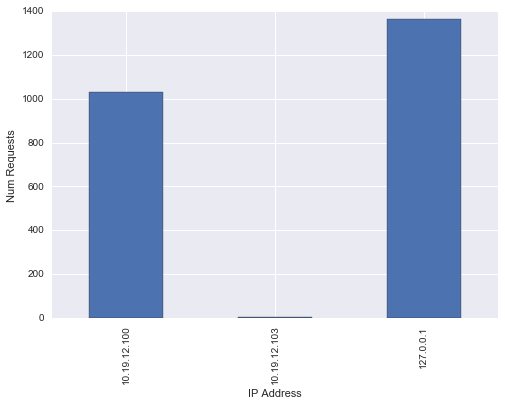

In [14]:
grouped_status2 = df_2kb.groupby('USX_IP')
g=grouped_status2.size().plot(kind='bar')
g.set_xlabel("IP Address")
g.set_ylabel("Num Requests")

temp = df_2kb['USX_IP'].value_counts()
temp.sort_values(ascending=False, inplace=True)
df1 = pd.DataFrame({'USX_IP':temp.index, 'Call Count':temp.values})
df1

What are the status of these large rest response api calls and count?

,Call Count,Status (respose_size > 2KB)
0,2396,200


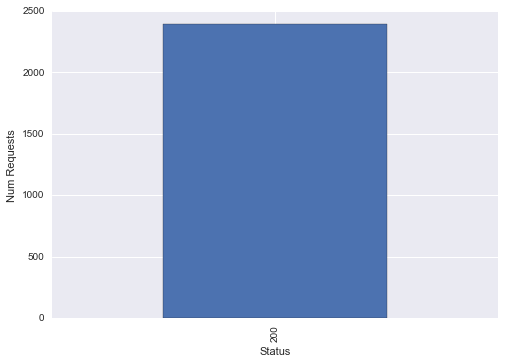

In [15]:
grouped_status1 = df_2kb.groupby('Status')
g=grouped_status1.size().plot(kind='bar')
g.set_xlabel("Status")
g.set_ylabel("Num Requests")

temp = df_2kb['Status'].value_counts()
temp.sort_values(ascending=False, inplace=True)
df1 = pd.DataFrame({'Status (respose_size > 2KB)':temp.index, 'Call Count':temp.values})
df1

What are these frequently called REST APIs whose response size > 2KB?

In [16]:
temp = df_2kb['Request'].value_counts()
temp.sort_values(ascending=False, inplace=True)
df1 = pd.DataFrame({'Top APIs (respose_size > 2KB)':temp.index, 'Call Count':temp.values})
df1

,Call Count,Top APIs (respose_size > 2KB)
0,2053,GET /usxmanager/usx/inventory/volume/container...
1,291,GET /usxmanager/license HTTP/1.1
2,36,GET /usxmanager/policies/USX_f328fe59-1b30-37d...
3,8,GET /usxmanager/policies?query=.%5Bgroup%3D'in...
4,4,GET /usxmanager/usx/inventory/volume/container...
5,2,GET /usxmanager/usx/inventory/volume/container...
6,2,GET /usxmanager/plugins HTTP/1.1


### Additional Investigations...

We have too many calls from 127.0.0.1 (see 1st section for details). What are the calls?

In [17]:
print("Printing last 10 calls from 127.0.0.1...")
df[df.USX_IP =='127.0.0.1'].tail(10)

Printing last 10 calls from 127.0.0.1...


,Status,USX_IP,Method,Request,Size
Time,,,,,
2016-09-08 22:27:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0
2016-09-08 22:28:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0
2016-09-08 22:29:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0
2016-09-08 22:30:02,200,127.0.0.1,GET,GET /usxmanager/usxmanager HTTP/1.1,2
2016-09-08 22:30:07,200,127.0.0.1,GET,GET /usxmanager/usx/inventory/servicevm/contai...,0
2016-09-08 22:30:07,200,127.0.0.1,GET,GET /usxmanager/usx/inventory/volume/container...,NaN
2016-09-08 22:30:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0
2016-09-08 22:31:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0
2016-09-08 22:32:12,200,127.0.0.1,PUT,PUT /usxmanager/services/INSIGHT/10.19.12.100 ...,0
